Correct slit coord input. End point is farther from the image center than the start point.
Rotated 55.5610106911964° in clockwise to make the slit upright.


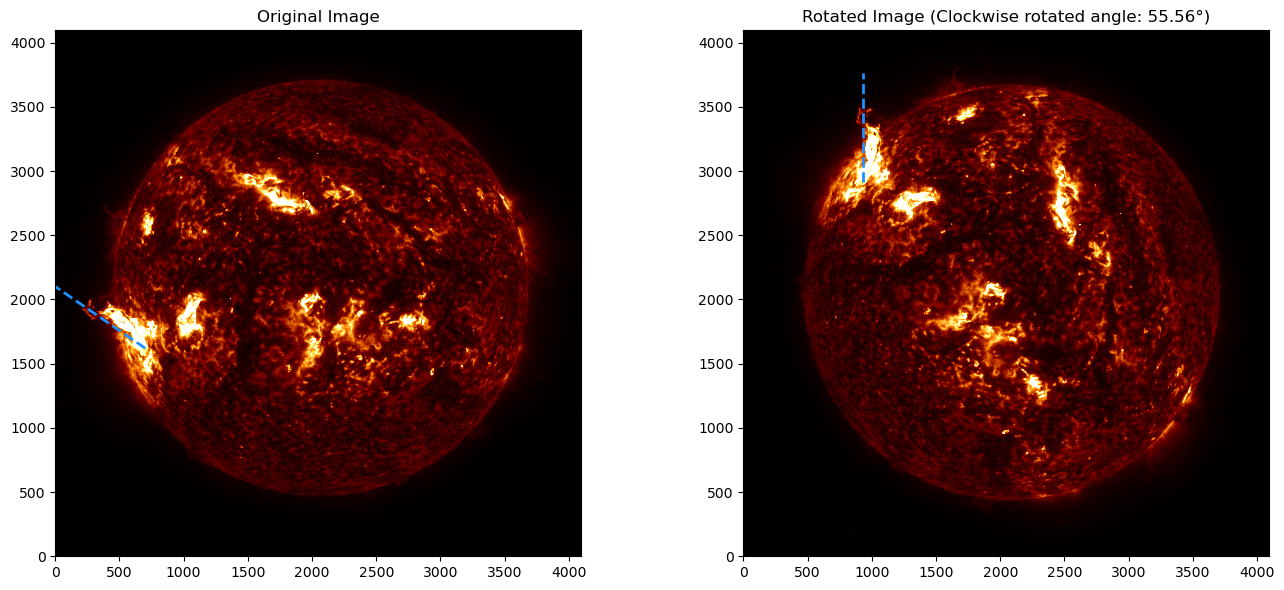

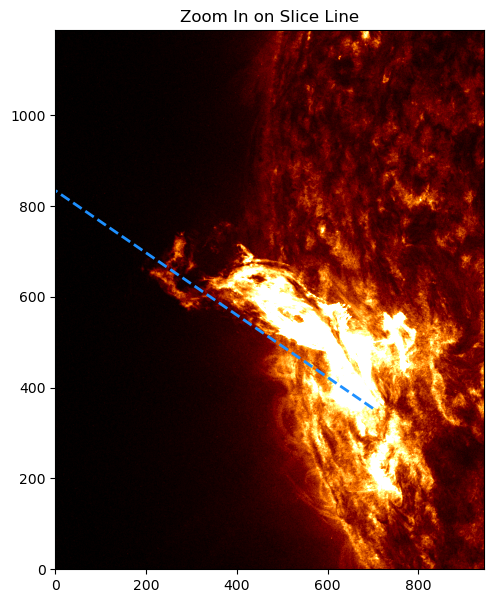

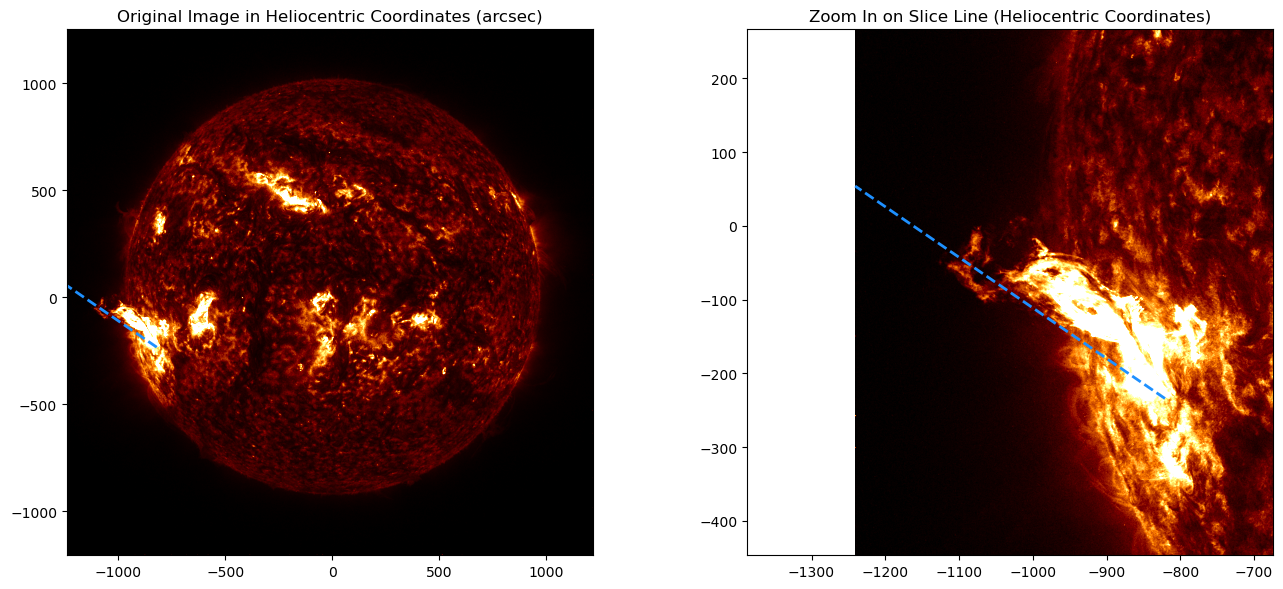

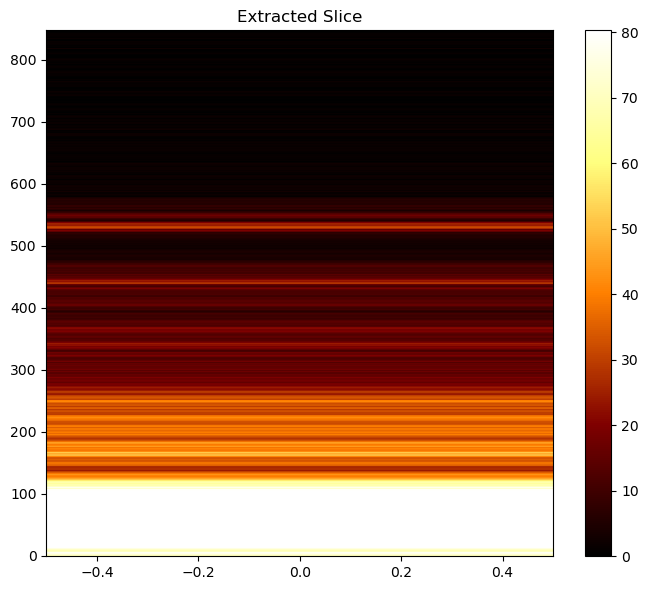

In [2]:

# extract a single slice from a single fits file

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import rotate
import os

def read_fits(file_path):
    rsm = fits.open(file_path)
    data = rsm[1].data
    header = rsm[1].header
    rsm.close()
    return np.flipud(data), header

def pixel_to_heliocentric(x, y, header):
    xc = header['CRPIX1']
    yc = header['CRPIX2']
    scale = header['CDELT1']  # arcsec per pixel
    x_heliocentric = (x - xc) * scale
    y_heliocentric = (y - yc) * scale
    return x_heliocentric, y_heliocentric

def compute_rotation_angle(start, end):
    dy = start[1] - end[1]
    dx = end[0] - start[0]
    angle = np.arctan2(dy, dx) * 180 / np.pi
    # print(angle)
    # print(dx)
    if dx < 0:
        if angle < 0:
            return (np.abs(angle) - 90)
        else:
            return (- angle - 90)
    else:
        if angle < 0:
            return (- angle - 90)
        else:
            return (- angle - 90)

def rotate_point(x, y, angle, center):
    angle_rad = np.radians(angle)
    x_c, y_c = center
    x_new = (x - x_c) * np.cos(angle_rad) - (y - y_c) * np.sin(angle_rad) + x_c
    y_new = (x - x_c) * np.sin(angle_rad) + (y - y_c) * np.cos(angle_rad) + y_c
    return x_new, y_new

def compute_distance_and_comparison(start, end, data):
   
    center = (data.shape[1] / 2, data.shape[0] / 2)

    def calculate_distance(point, center):
        x, y = point
        x_c, y_c = center
        return np.sqrt((x - x_c)**2 + (y - y_c)**2)
    
    start_distance = calculate_distance(start, center)
    end_distance = calculate_distance(end, center)

    if start_distance > end_distance:
        return "Warning: Start point is farther from the image center than the end point. Please exchange the coords."
    elif start_distance < end_distance:
        return "Correct slit coord input. End point is farther from the image center than the start point."
    else:
        return "Please note that start point and end point are equidistant from the image center."

def rotate_image(data, angle):
    return rotate(data, angle, reshape=False)

def plot_images_and_slice(original_data, rotated_data, start, end, zoom_percent):
    # show original img and rotated img
    # draw the slit line on imgs
    # plt the zoom-in picture

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    vmin = 0
    vmax = original_data.mean() * 10

    # original img
    axes[0].imshow(original_data, origin='lower', cmap='afmhot', vmin=vmin, vmax=vmax)
    axes[0].set_title('Original Image')
    axes[0].plot([start[0], end[0]], [start[1], end[1]], color='#1E90FF', lw=2, linestyle='--')
    
    # rotated img, to make the slit upright and be (mostly) in the upper part
    angle = compute_rotation_angle(start, end)
    center = (original_data.shape[1] / 2, original_data.shape[0] / 2)
    start_rotated = rotate_point(start[0], start[1], -angle, center)
    end_rotated = rotate_point(end[0], end[1], -angle, center)
    
    axes[1].imshow(rotated_data, origin='lower', cmap='afmhot', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'Rotated Image (Clockwise rotated angle: {angle:.2f}°)')
    axes[1].plot([start_rotated[0], end_rotated[0]], [start_rotated[1], end_rotated[1]], color='#1E90FF', lw=2, linestyle='--')

    plt.tight_layout()
    plt.show()

    # Zoom-In img
    line_length = np.linalg.norm([start_rotated[0] - end_rotated[0], start_rotated[1] - end_rotated[1]])
    zoom_margin = line_length * zoom_percent
    center_x = (start[0] + end[0]) / 2
    center_y = (start[1] + end[1]) / 2

    half_size = int(zoom_margin)
    x_min = max(0, int(center_x - half_size))
    x_max = min(original_data.shape[1], int(center_x + half_size))
    y_min = max(0, int(center_y - half_size))
    y_max = min(original_data.shape[0], int(center_y + half_size))

    zoom_in_data = original_data[y_min:y_max, x_min:x_max]
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(zoom_in_data, origin='lower', cmap='afmhot', vmin=vmin, vmax=vmax)
    ax.set_title('Zoom In on Slice Line')
    
    # plt the slit on zoom-in img
    start_zoomed = (start[0] - x_min, start[1] - y_min)
    end_zoomed = (end[0] - x_min, end[1] - y_min)
    ax.plot([start_zoomed[0], end_zoomed[0]], [start_zoomed[1], end_zoomed[1]], color='#1E90FF', lw=2, linestyle='--')
    
    plt.show()

def plot_heliocentric_images(data, header, start, end, zoom_percent):
    # show the plots again in heliocentric coords

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    vmin = 0
    vmax = data.mean() * 10   # should be modified

    # compute the Heliocentric coords
    x_heliocentric = np.arange(data.shape[1])
    y_heliocentric = np.arange(data.shape[0])
    x_heliocentric, y_heliocentric = np.meshgrid(x_heliocentric, y_heliocentric)

    x_heliocentric, y_heliocentric = pixel_to_heliocentric(x_heliocentric, y_heliocentric, header)
    start_heliocentric = pixel_to_heliocentric(start[0], start[1], header)
    end_heliocentric = pixel_to_heliocentric(end[0], end[1], header)

    # original
    axes[0].imshow(data, origin='lower', cmap='afmhot', vmin=vmin, vmax=vmax,
                    extent=[x_heliocentric.min(), x_heliocentric.max(), y_heliocentric.min(), y_heliocentric.max()])
    axes[0].set_title('Original Image in Heliocentric Coordinates (arcsec)')
    axes[0].plot([start_heliocentric[0], end_heliocentric[0]], [start_heliocentric[1], end_heliocentric[1]], color='#1E90FF', lw=2, linestyle='--')

    # Zoom-In 
    line_length = np.linalg.norm(np.array(start_heliocentric) - np.array(end_heliocentric))
    zoom_margin = line_length * zoom_percent
    center_x = (start_heliocentric[0] + end_heliocentric[0]) / 2
    center_y = (start_heliocentric[1] + end_heliocentric[1]) / 2

    x_min = center_x - zoom_margin
    x_max = center_x + zoom_margin
    y_min = center_y - zoom_margin
    y_max = center_y + zoom_margin

    axes[1].imshow(data, origin='lower', cmap='afmhot', vmin=vmin, vmax=vmax,
                    extent=[x_heliocentric.min(), x_heliocentric.max(), y_heliocentric.min(), y_heliocentric.max()])
    axes[1].set_xlim(x_min, x_max)
    axes[1].set_ylim(y_min, y_max)
    axes[1].set_title('Zoom In on Slice Line (Heliocentric Coordinates)')
    axes[1].plot([start_heliocentric[0], end_heliocentric[0]], [start_heliocentric[1], end_heliocentric[1]], color='#1E90FF', lw=2, linestyle='--')

    plt.tight_layout()
    plt.show()
    return vmin, vmax

def extract_slice(data, start, end, delta_pix, center, angle, vmin, vmax):
   
    data = np.clip(data, vmin, vmax)
    start_rotated = rotate_point(start[0], start[1], -angle, center)
    end_rotated = rotate_point(end[0], end[1], -angle, center)
    
    # compute the direction of slit
    dy = end_rotated[1] - start_rotated[1]
    dx = end_rotated[0] - start_rotated[0]
    
    # create a pixel stripe along the slit with width of delta_pix
    # compute the slope of slit line, get coord of each point on the slit line
    # extract the stripe
    perp_slope = -dx / dy if dy != 0 else 0  
    
    slice_pixels = []
    for t in np.linspace(0, 1, num=int(np.linalg.norm([dx, dy]))):  # interpolation along the slit 
        x = int(start_rotated[0] + t * dx)
        y = int(start_rotated[1] + t * dy)
        
        for i in range(-delta_pix//2, delta_pix//2):
            x_offset = int(i * np.cos(np.arctan(perp_slope)))
            y_offset = int(i * np.sin(np.arctan(perp_slope)))
            if 0 <= y + y_offset < data.shape[0] and 0 <= x + x_offset < data.shape[1]:
                slice_pixels.append(data[y + y_offset, x + x_offset])
    
    return np.array(slice_pixels).reshape(-1, delta_pix)

def save_and_show_slice(slice_data, output_dir, file_name, fits_path):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # add the name of original fits file to the slice file name
    fits_name = os.path.basename(fits_path).replace('.fits', '')

    file_name = f"{fits_name}_{file_name}"

    fig, ax = plt.subplots(figsize=(7, 6))

    im = ax.imshow(slice_data, cmap='afmhot', origin='lower', aspect='auto')
    ax.set_title('Extracted Slice')
    fig.colorbar(im, ax=ax)  

    plt.tight_layout()
    plt.show()

    output_path = os.path.join(output_dir, file_name)
    plt.imsave(output_path, np.flipud(slice_data), cmap='afmhot')

def process_and_extract_slice(data, start_point, end_point, delta_pix, output_dir, vmin, vmax):
    # compute the rotation angle   
    # extract slice
    # save the slice

    angle = compute_rotation_angle(start_point, end_point)
    center = (data.shape[1] / 2, data.shape[0] / 2)

    slice_data = extract_slice(data, start_point, end_point, delta_pix, center, angle, vmin, vmax)
    
    file_name = f"slice_{start_point[0]}_{start_point[1]}_{end_point[0]}_{end_point[1]}.png"
    save_and_show_slice(slice_data, output_dir, file_name, file_path)


# slit parameters input
# start point coord must be nearer than end point to the image centre
file_path = "/data2/pqf_SDO_SolO/data_SDO/2023_10_02_120007/aia.lev1_euv_12s.2023-10-02T125131Z.304.image_lev1.fits"
data, header = read_fits(file_path)
start_point = (700, 1620)
end_point =  (0, 2100)  

# check if start point coord is nearer than end point to the image centre
result = compute_distance_and_comparison(start_point, end_point, data)
print(result)

angle = compute_rotation_angle(start_point, end_point)
print(f"Rotated {angle}° in clockwise to make the slit upright.")

rotated_data = rotate_image(data, angle)
zoom_percent = 0.7
plot_images_and_slice(data, rotated_data, start_point, end_point, zoom_percent)
vmin, vmax = plot_heliocentric_images(data, header, start_point, end_point, zoom_percent)

# extracte and save slice png
delta_pix = 1   # the width of slice (in pix)
output_each_slice_dir = "/data2/pqf_SDO_SolO/SDO/tests"  
process_and_extract_slice(rotated_data, start_point, end_point, delta_pix, output_each_slice_dir, vmin, vmax)


# print("CUNIT1:", header.get('CUNIT1', 'Unknown'))
# print("CUNIT2:", header.get('CUNIT2', 'Unknown'))

# saved file_name = f"slice_{start_point[0]}_{start_point[1]}_{end_point[0]}_{end_point[1]}.png"

